# Fraud Detection Case Study

In [1]:
import numpy as np
import pandas as pd
from itertools import *
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC

from numpy.linalg import svd

import matplotlib.pyplot as plt
%matplotlib inline

import random
import cPickle as pickle


In [2]:
data = pd.read_json('../../data.json')

Singular Value Decomposition (To reduce the number of features) -

https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html



In [3]:
data.head(3)

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{u'event_id': 527017, u'cost': 25.0, u'availa...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{u'event_id': 786878, u'cost': 35.0, u'availa...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{u'event_id': 787337, u'cost': 93.51, u'avail...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA


In [4]:
data['acct_type'].unique()

array([u'fraudster_event', u'premium', u'spammer_warn', u'fraudster',
       u'spammer_limited', u'spammer_noinvite', u'locked', u'tos_lock',
       u'tos_warn', u'fraudster_att', u'spammer_web', u'spammer'], dtype=object)

In [5]:
Counter(data['acct_type'])

Counter({u'fraudster': 437,
         u'fraudster_att': 5,
         u'fraudster_event': 851,
         u'locked': 54,
         u'premium': 12373,
         u'spammer': 1,
         u'spammer_limited': 218,
         u'spammer_noinvite': 84,
         u'spammer_warn': 144,
         u'spammer_web': 2,
         u'tos_lock': 77,
         u'tos_warn': 91})

In [6]:
# data[data['acct_type']=='locked']

In [7]:
a_loon = {'fraudster': 1, 'fraudster_att': 1, 'fraudster_event': 1, 'locked': 1, 'premium': 0}


In [8]:
df_first = data[(data['acct_type']=='fraudster') | (data['acct_type']=='fraudster_att') | (data['acct_type']=='fraudster_event')
    | (data['acct_type']=='premium')]

In [9]:
y = df_first['acct_type'].map(a_loon)

In [10]:
df_first.columns

Index([u'acct_type', u'approx_payout_date', u'body_length', u'channels',
       u'country', u'currency', u'delivery_method', u'description',
       u'email_domain', u'event_created', u'event_end', u'event_published',
       u'event_start', u'fb_published', u'gts', u'has_analytics',
       u'has_header', u'has_logo', u'listed', u'name', u'name_length',
       u'num_order', u'num_payouts', u'object_id', u'org_desc',
       u'org_facebook', u'org_name', u'org_twitter', u'payee_name',
       u'payout_type', u'previous_payouts', u'sale_duration',
       u'sale_duration2', u'show_map', u'ticket_types', u'user_age',
       u'user_created', u'user_type', u'venue_address', u'venue_country',
       u'venue_latitude', u'venue_longitude', u'venue_name', u'venue_state'],
      dtype='object')

In [11]:
# df_first[(df_first['fb_published'] == 1) & (df_first['acct_type'] == 'premium') ]

In [12]:
df_first['regi_use_time_delta'] = df_first['event_created'] - df_first['user_created']

/home/sanhita/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
# df_first[['regi_use_time_delta', 'acct_type']]

In [14]:
df_first[df_first['acct_type'].str.contains('fraud')]['regi_use_time_delta'].mean()

7528982.6055684453

In [15]:
df_first[df_first['acct_type'].str.contains('premium')]['regi_use_time_delta'].mean()

34292148.041461244

In [16]:
col = 'show_map'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.756380510441

0.850804170370969

In [17]:
col = 'fb_published'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.0224284609435

0.13569869877960075

In [18]:
col = 'has_logo'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.645784996133

0.86106845550796085

In [19]:
col = 'has_header'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.0693641618497

0.21320754716981133

In [84]:
col = 'has_header'
df_first[col].unique()

array([  1.,   0.,  nan])

In [20]:
col = 'org_facebook'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

1.03554119548

8.60037189748565

array([  0.,  18.,   8.,  17.,  13.,  16.,  29.,  19.,  10.,  15.,   9.,
        26.,   6.,  11.,  35.,  20.,  40.,  48.,  12.,   5.,  22.,  34.,
        14.,  24.,   7.,  43.,  25.,  23.,  36.,  21.,  32.,  45.,  91.,
        39.,  52.,  51.,  33.,  27.,  37.,  66.,  78.,  62.,  46.,  nan,
        28.,  30.,  61.,  83.,  56.,  44.,  47.,  42.,  63.,  53.,  76.,
        41.,  38.,  31.,  69.,  71.,  50.,  55.,  49.,  81.,  88.,  64.,
        70.,   4.,  57.,  58.,  59.,   3.,  54.,  73.,  65.,  72.,  67.,
        60.,  80.,  85.,  75.,  79.])

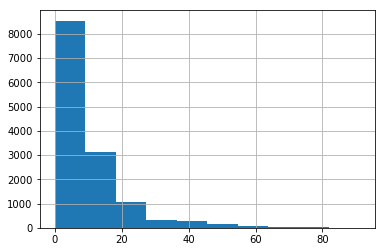

In [87]:
df_first['org_facebook'].hist()
df_first['org_facebook'].unique()

In [22]:
col = 'listed'
yn_map = {'y': 1, 'n' : 0}
df_first['listed'] = df_first['listed'].map(yn_map)
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.832173240526

/home/sanhita/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0.85702739836741293

In [23]:
col = 'org_twitter'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.294022617124

4.652680087315062

array([  0.,  12.,   8.,  15.,  14.,  11.,  16.,   5.,   6.,  10.,   9.,
        13.,   7.,   2.,  17.,  18.,  nan,  20.,  21.,   4.,  23.,  34.,
         3.,  19.])

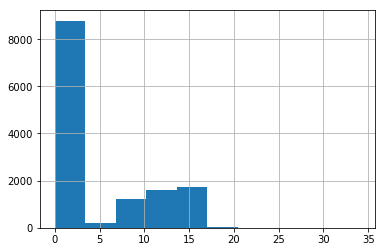

In [86]:
col = 'org_twitter'
df_first[col].hist()
df_first[col].unique()

In [89]:
col = 'sale_duration'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()


14.1259574468

50.395477020345304

In [25]:
col = 'gts'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

1911.21436195

2531.424853309616

In [26]:
col = 'has_analytics'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()
df_first[col].

0.0030935808198

0.082033459953123736

In [27]:
df_first.columns

Index([          u'acct_type',  u'approx_payout_date',         u'body_length',
                  u'channels',             u'country',            u'currency',
           u'delivery_method',         u'description',        u'email_domain',
             u'event_created',           u'event_end',     u'event_published',
               u'event_start',        u'fb_published',                 u'gts',
             u'has_analytics',          u'has_header',            u'has_logo',
                    u'listed',                u'name',         u'name_length',
                 u'num_order',         u'num_payouts',           u'object_id',
                  u'org_desc',        u'org_facebook',            u'org_name',
               u'org_twitter',          u'payee_name',         u'payout_type',
          u'previous_payouts',       u'sale_duration',      u'sale_duration2',
                  u'show_map',        u'ticket_types',            u'user_age',
              u'user_created',           u'user_type

In [28]:
col = 'name_length'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

29.9752513534

42.479915946011474

In [29]:
col = 'payee_name'
df_first[df_first[col]==u''][['acct_type', col]]
f_name = df_first[(df_first['acct_type'].str.contains('fraud')) & (df_first[col]==u'')]['acct_type'].count()
p_name = df_first[(df_first['acct_type'].str.contains('premium')) & (df_first[col]==u'')]['acct_type'].count()

print f_name*1.0 / len(df_first[df_first['acct_type'].str.contains('fraud')]), 
p_name*1.0 / len(df_first[df_first['acct_type'].str.contains('premium')])

0.976798143852

0.75850642528085344

In [30]:
col = 'payout_type'
df_first[col].unique()
# df_first[(df_first['acct_type'].str.contains('premium')) & (df_first[col] != 'CHECK') & (df_first[col] != 'ACH')][['acct_type', col]]

array([u'', u'CHECK', u'ACH'], dtype=object)

In [31]:
df_first[(df_first['acct_type'].str.contains('fraud')) & (df_first[col] != 'CHECK') & (df_first[col] != 'ACH')][['acct_type', col]]

,acct_type,payout_type
0,fraudster_event,
183,fraudster,
187,fraudster_event,
212,fraudster_event,
219,fraudster_event,
289,fraudster_event,
296,fraudster_event,
307,fraudster_event,
330,fraudster_event,
440,fraudster_event,


In [32]:
col = 'num_payouts'
# df_first[col]
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

0.582366589327

37.432635577467067

In [33]:
col = 'name_length'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

29.9752513534

42.479915946011474

In [34]:
col = 'previous_payouts'

df_first[df_first['acct_type'].str.contains('premium')][col]


for i in xrange(len(df_first)):
    
    len(df_first[col][0])

In [35]:
col = 'previous_payouts'
length_list = []

for i in xrange(len(df_first)):
#     length_list.append(len(df_first[col][i]))
    length_list.append(((len(df_first.iloc[i][col]), i)))
    
max(length_list)

(2048, 12138)

In [36]:
for i in xrange(10):
    if 'premium' in str(df_first['acct_type'][i]):
        print True
    elif 'fraud' in str(df_first['acct_type'][i]):
        print False
    else:
        print 'Bummer'

False
True
True
True
True
True
True
True
True
True


In [37]:
col = 'previous_payouts'
length_list_fraud = []
length_list_gen = []

for i in xrange(len(df_first)):
    if 'premium' in str(df_first['acct_type'][i]):
        length_list_gen.append(((len(df_first.iloc[i][col]), i)))
    elif 'fraud' in str(df_first['acct_type'][i]):
        length_list_fraud.append(((len(df_first.iloc[i][col]), i)))
    else : 
        continue

print max(length_list_gen), min(length_list_gen), np.mean(length_list_gen)

KeyError: 13

In [189]:
df_first.iloc[12138][['acct_type', col]]

acct_type                                                     premium
previous_payouts    [{u'name': u'Seneca Lake Winery Association', ...
Name: 12732, dtype: object

In [91]:
col = 'ticket_types'
type(df_first[col][0][0])

dict

In [184]:
col = 'ticket_types'
length_list = []

for i in xrange(len(df_first)):
#     length_list.append(len(df_first[col][i]))
    length_list.append(((len(df_first.iloc[i][col]), i)))
    
max(length_list)

(116, 9258)

In [186]:
df_first.iloc[9258][col]

[{u'availability': 1,
  u'cost': 100.0,
  u'event_id': 3814948,
  u'quantity_sold': 8,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 75.0,
  u'event_id': 3814948,
  u'quantity_sold': 4,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 75.0,
  u'event_id': 3814948,
  u'quantity_sold': 4,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 3814948,
  u'quantity_sold': 2,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 3814948,
  u'quantity_sold': 6,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 3814948,
  u'quantity_sold': 8,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 3814948,
  u'quantity_sold': 4,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 3814948,
  u'quantity_sold': 3,
  u'quantity_total': 1},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 3814948,
  u'quantity_sold': 2,
  u'quantity_total': 1},


In [107]:
lst = df_first[col]

In [134]:
len(df_first)
for i in xrange(50):
    t = pd.DataFrame(lst[i])
    print i, t.iloc[:, 3].sum(), df_first['acct_type'][i]

0 0 fraudster_event
1 25 premium
2 48 premium
3 58 premium
4 39 premium
5 37 premium
6 36 premium
7 57 premium
8 14 premium
9 64 premium
10 33 premium
11 21 premium
12 7 premium


KeyError: 13

In [109]:
df_tt

,ticket_types
0,"[{u'event_id': 527017, u'cost': 25.0, u'availa..."
1,"[{u'event_id': 786878, u'cost': 35.0, u'availa..."
2,"[{u'event_id': 787337, u'cost': 93.51, u'avail..."
3,"[{u'event_id': 885645, u'cost': 25.0, u'availa..."
4,"[{u'event_id': 1114349, u'cost': 150.0, u'avai..."
5,"[{u'event_id': 1179983, u'cost': 8.0, u'availa..."
6,"[{u'event_id': 1180179, u'cost': 22.63, u'avai..."
7,"[{u'event_id': 1180391, u'cost': 14.0, u'avail..."
8,"[{u'event_id': 1180423, u'cost': 250.0, u'avai..."
9,"[{u'event_id': 1180435, u'cost': 14.0, u'avail..."


In [41]:
df_first[['ticket_types', 'previous_payouts']].from_records

<bound method type.from_records of <class 'pandas.core.frame.DataFrame'>>

In [67]:
col = 'previous_payouts'

lst_prev_pay = []
for i in xrange(len(df_first)):
# for i in xrange(20):
     lst_prev_pay.append((len(df_first.iloc[i][col]), df_first.iloc[i]['acct_type']))
#         print len(df_first.iloc[i][col])

In [74]:
list_prev_pay = [list(elem) for elem in lst_prev_pay]

In [83]:
for i in xrange(len(list_prev_pay)):
# for i in xrange(20):
    total = 0
    count = 0
    if 'fraud' in list_prev_pay[i][1]:
        total += list_prev_pay[i][0]
        count += 1
#         print 'fraud'
        
print total*1.0, count

0.0 1


In [75]:
len(list_prev_pay)

13666

In [112]:
df_first[df_first['acct_type'].str.contains('fraud')]['ticket_types']

0        [{u'event_id': 527017, u'cost': 25.0, u'availa...
26       [{u'event_id': 1386643, u'cost': 300.0, u'avai...
51       [{u'event_id': 1928009, u'cost': 30.0, u'avail...
54       [{u'event_id': 1964043, u'cost': 500.0, u'avai...
70       [{u'event_id': 2228484, u'cost': 30.0, u'avail...
128      [{u'event_id': 3048157, u'cost': 150.0, u'avai...
130      [{u'event_id': 3090085, u'cost': 140.76, u'ava...
131      [{u'event_id': 3104463, u'cost': 200.0, u'avai...
140      [{u'event_id': 3244275, u'cost': 140.76, u'ava...
144      [{u'event_id': 3310151, u'cost': 235.0, u'avai...
149      [{u'event_id': 3423729, u'cost': 35.0, u'avail...
161      [{u'event_id': 3493645, u'cost': 8.46, u'avail...
177      [{u'event_id': 3717486, u'cost': 100.0, u'avai...
181      [{u'event_id': 3798244, u'cost': 22.0, u'avail...
183      [{u'event_id': 3801364, u'cost': 350.0, u'avai...
187      [{u'event_id': 3833884, u'cost': 2.0, u'availa...
202      [{u'event_id': 3998400, u'cost': 100.0, u'avai.

In [114]:
df_first[df_first['acct_type'].str.contains('fraud')]['ticket_types'][14114]

[{u'availability': 1,
  u'cost': 73.0,
  u'event_id': 2940967,
  u'quantity_sold': 0,
  u'quantity_total': 8},
 {u'availability': 1,
  u'cost': 171.0,
  u'event_id': 2940967,
  u'quantity_sold': 1,
  u'quantity_total': 8}]

In [101]:
col = 'previous_payouts'

for i in xrange(len(df_first)):
    total_payout = 0
    count_payouts = len(df_first.iloc[i][col])

    for d in df_first.iloc[i][col]:
        total_payout = d['amount']

    print total_payout, count_payouts

0 0
4715.34 49
2406.83 36
200.06 21
285.0 49
252.0 5
140.0 15
634.0 470
5197.5 2
634.0 470
569.98 96
520.0 262
92.56 50
680.0 8
70.0 1264
70.0 1264
30.0 1
2694.0 11
8645.08 11
1889.0 1
356.42 31
3661.66 13
214.92 207
1190.0 2
135.0 406
0 0
499.7 192
20884.52 216
1615.0 15
5545.0 3
44.0 44
124.62 2
285.0 49
7906.32 6
357.13 2
1118.0 14
936.0 12
3214.74 6
1.0 1
145.38 2
300.0 4
45.0 2
510.0 7
1083.41 2
37.42 77
100.0 3
45.0 14
90.0 1
12.19 10
308.32 2
5897.0 1
234.0 17
0 0
1133.84 72
70.0 1264
976.24 57
80.0 1
280.0 1
976.24 57
7115.0 3
658.17 3
245.0 12
100.0 11
60.0 2
60.0 1
994.62 9
4002.98 10
0 0
905.2 13
67.68 143
71.64 1
20.0 60
20.0 60
6071.0 4
47.0 3
17.5 2
1000.0 1
3699.84 11
7.11 133
4130.34 31
109.02 5
40.0 1
910.0 1
120.95 1666
760.0 5
703.03 394
2589.15 55
275.0 4
150.0 434
1003.26 4
90.0 157
50.0 32
10720.0 4
960.05 12
253.62 3
1640.17 24
613.0 3
831.78 41
196.55 148
15.0 253
4825.75 5
89.04 3
10720.0 4
595.93 31
99.98 121
183.28 4
7.46 45
89.05 9
158.61 1
102.0 1
4775.0 2


In [122]:
col = 'previous_payouts'

lst = []
for i in xrange(len(df_first)):
    total_payout = 0
    count_payouts = len(df_first.iloc[i][col])

    for d in df_first.iloc[i][col]:
        total_payout = d['amount']

    lst.append((total_payout, count_payouts, df_first.iloc[i]['acct_type']))

In [135]:
sum_fraud = 0
sum_prem = 0
for i in xrange(len(lst)):
    if 'fraud' in lst[i][-1]:
        sum_fraud += lst[i][0]
    elif 'premium' in lst[i][-1]:
        sum_prem += lst[i][0]

print sum_fraud/1300, sum_prem/13000

183.883123077 2340.55822


In [136]:
col = 'ticket_types'
df_first[col][0]

[{u'availability': 1,
  u'cost': 25.0,
  u'event_id': 527017,
  u'quantity_sold': 0,
  u'quantity_total': 800},
 {u'availability': 1,
  u'cost': 50.0,
  u'event_id': 527017,
  u'quantity_sold': 0,
  u'quantity_total': 100},
 {u'availability': 1,
  u'cost': 550.0,
  u'event_id': 527017,
  u'quantity_sold': 0,
  u'quantity_total': 20}]

In [176]:
col = 'ticket_types'

lst_tt = []
for i in xrange(len(df_first)):
    quantity_sold = 0
    cost_tickets = 0
    quantity_total = 0
    count_tickets = len(df_first.iloc[i][col])

    for d in df_first.iloc[i][col]:
        quantity_sold += d['quantity_sold']
        cost_tickets += d['cost']*d['quantity_sold']
        quantity_total += d['quantity_total']
        if d['quantity_sold'] > d['quantity_total']:
            print 'Sold tickets are more than total, for row ', i
    lst_tt.append((quantity_sold, cost_tickets, quantity_total, count_tickets, df_first.iloc[i]['acct_type']))

Sold tickets are more than total, for row  58
Sold tickets are more than total, for row  60
Sold tickets are more than total, for row  60
Sold tickets are more than total, for row  60
Sold tickets are more than total, for row  60
Sold tickets are more than total, for row  60
Sold tickets are more than total, for row  89
Sold tickets are more than total, for row  114
Sold tickets are more than total, for row  114
Sold tickets are more than total, for row  120
Sold tickets are more than total, for row  144
Sold tickets are more than total, for row  177
Sold tickets are more than total, for row  207
Sold tickets are more than total, for row  208
Sold tickets are more than total, for row  245
Sold tickets are more than total, for row  248
Sold tickets are more than total, for row  248
Sold tickets are more than total, for row  248
Sold tickets are more than total, for row  248
Sold tickets are more than total, for row  298
Sold tickets are more than total, for row  302
Sold tickets are mor

In [183]:
df_first['ticket_types'][58]

[{u'availability': 1,
  u'cost': 20.0,
  u'event_id': 2031653,
  u'quantity_sold': 6,
  u'quantity_total': 350},
 {u'availability': 1,
  u'cost': 0.0,
  u'event_id': 2031653,
  u'quantity_sold': 0,
  u'quantity_total': 350},
 {u'availability': 1,
  u'cost': 20.0,
  u'event_id': 2031653,
  u'quantity_sold': 2,
  u'quantity_total': 350},
 {u'availability': 1,
  u'cost': 0.0,
  u'event_id': 2031653,
  u'quantity_sold': 0,
  u'quantity_total': 350}]

In [175]:
sum_fraud = 0
sum_prem = 0
sum_total = 0
sum_prem_t = 0
for i in xrange(len(lst)):
    if 'fraud' in lst[i][-1]:
        sum_fraud += lst_tt[i][0]
        sum_total += lst_tt[i][2]
    elif 'premium' in lst[i][-1]:
        sum_prem += lst_tt[i][0]*1.0
        sum_prem_t += lst_tt[i][2]

    else : continue

print sum_fraud/1300, sum_total/ 1300, sum_prem/13000, sum_prem_t /13000

4 55100 69.6019230769 2018


In [149]:
corr = np.stack((np.array(lst), np.array(lst_tt)), axis=1)

In [150]:
corr[:][0]

array([[u'0', u'0', u'fraudster_event'],
       [u'0.0', u'625.0', u'3.0']], 
      dtype='<U32')

In [152]:
df_first.columns

Index([          u'acct_type',  u'approx_payout_date',         u'body_length',
                  u'channels',             u'country',            u'currency',
           u'delivery_method',         u'description',        u'email_domain',
             u'event_created',           u'event_end',     u'event_published',
               u'event_start',        u'fb_published',                 u'gts',
             u'has_analytics',          u'has_header',            u'has_logo',
                    u'listed',                u'name',         u'name_length',
                 u'num_order',         u'num_payouts',           u'object_id',
                  u'org_desc',        u'org_facebook',            u'org_name',
               u'org_twitter',          u'payee_name',         u'payout_type',
          u'previous_payouts',       u'sale_duration',      u'sale_duration2',
                  u'show_map',        u'ticket_types',            u'user_age',
              u'user_created',           u'user_type

In [153]:
col = 'email_domain'
df_first[df_first[col]==u''][['acct_type', col]]
f_name = df_first[(df_first['acct_type'].str.contains('fraud')) & (df_first[col]==u'')]['acct_type'].count()
p_name = df_first[(df_first['acct_type'].str.contains('premium')) & (df_first[col]==u'')]['acct_type'].count()

print f_name*1.0 / len(df_first[df_first['acct_type'].str.contains('fraud')]), 
p_name*1.0 / len(df_first[df_first['acct_type'].str.contains('premium')])

0.0

0.0

In [157]:
col = 'num_order'
# df_first[col]
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

4.5305491106

30.527842883698376

In [169]:
col = 'channels'
# df_first[col].unique()
# df_first[df_first['acct_type'].str.contains('fraud')][['acct_type', col]]
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

4.14926527456

6.3737169643578762

In [170]:
col = 'body_length'
print df_first[df_first['acct_type'].str.contains('fraud')][col].mean(), 
df_first[df_first['acct_type'].str.contains('premium')][col].mean()

1508.8863109

3813.3581184837954